# Data Preprocessing
Each letter is read and put into two dataframes - one for a processed list of words from each letter, another with a list of sentences from each letter. Word count is drastically reduced after stopwords (common words) are removed and stemming occurs. There is still a relatively large difference between shorter letters (early and later years) and longer letters.

In [1]:
import pandas as pd

# Prepare each letter and corresponding info to load into dataframe
years = []
letters = []
wcs = []
with open('data/letters.txt', 'r', encoding='utf8') as file:
    for count, line in enumerate(file):
        years.append(count+1977)
        letters.append(line)

        # Find word count without numbers and punctuation
        word_count = 0
        words = line.split()
        for word in words: 
            if word.isalpha(): word_count += 1
        wcs.append(word_count)

# Load letters into dataframe
df = pd.DataFrame()
df['Year'] = years
df['Letter'] = letters
df['Word Count'] = wcs
df.head()

,Year,Letter,Word Count
0,1977,To the Stockholders of Berkshire Hathaway Inc....,2842
1,1978,To the Shareholders of Berkshire Hathaway Inc....,3978
2,1979,To the Shareholders of Berkshire Hathaway Inc....,6282
3,1980,To the Shareholders of Berkshire Hathaway Inc....,7001
4,1981,To the Shareholders of Berkshire Hathaway Inc....,6151


In [2]:
import nltk
import re

# Define list of stopwords and stemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

# Process letters to get a list of words and a list of sentences
proc_words = []
proc_sents = []
for i, letter in enumerate(letters):

    # Split letter into list of words
    words = letter.split()
    words = [word for word in words if word.isalpha()]  # Remove punctuation and numbers
    words = [word.lower() for word in words if word.lower() not in stopwords]  # Remove stopwords
    stem_words = []
    for word in words:  # Create list of stemmed words
        if stemmer.stem(word) in stem_words: continue
        else: stem_words.append(stemmer.stem(word))
    proc_words.append(stem_words)

    # Split letter into list of sentences and remove figures
    sents = nltk.sent_tokenize(letter)
    for sent in sents:
        if (re.search("\.\.\.\.\.", sent)) is not None:  # Figures indicated by long elipses
            del sents[sents.index(sent)]
        if (re.search("\. \. \. \. ", sent)) is not None:  # 21st letter has spaces inbetween periods
            del sents[sents.index(sent)]
    proc_sents.append(sents)

# Load list of words into dataframe for ease of access
df_words = pd.DataFrame()
df_words['Year'] = years
df_words['Letter'] = proc_words
df_words['Word Count'] = [len(letter) for letter in proc_words]

# Load list of sentences into dataframe
df_sents = pd.DataFrame()
df_sents['Year'] = years
df_sents['Letter'] = proc_sents
df_sents['Sentence Count'] = [len(letter) for letter in proc_sents]
df_sents.head()

,Year,Letter,Sentence Count
0,1977,[To the Stockholders of Berkshire Hathaway Inc...,128
1,1978,[To the Shareholders of Berkshire Hathaway Inc...,162
2,1979,[To the Shareholders of Berkshire Hathaway Inc...,251
3,1980,[To the Shareholders of Berkshire Hathaway Inc...,310
4,1981,[To the Shareholders of Berkshire Hathaway Inc...,281


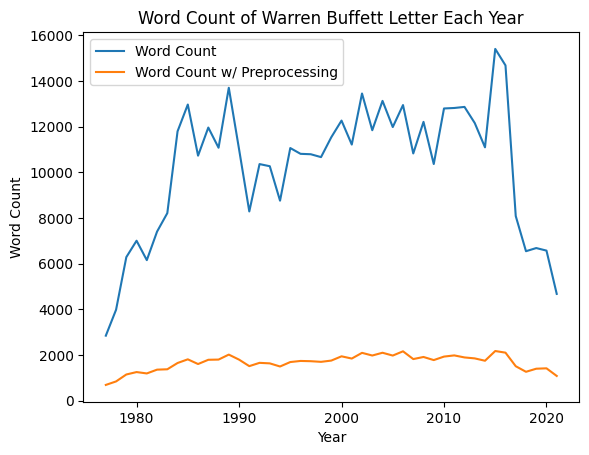

In [3]:
import matplotlib.pyplot as plt

# Plot hist of word counts
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(df['Year'], df['Word Count'], label='Word Count')
ax.plot(df_words['Year'], df_words['Word Count'], label='Word Count w/ Preprocessing')
ax.set_title('Word Count of Warren Buffett Letter Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Word Count')
ax.legend()

# Similarity - Count Vectorization
It was hypothesized that letters written before years of an increase in the market would be more similar to each other, as well as letters written before years of a decrease in the market. No real similarity was found between the letters using count vectorization. All letters are equally similar to each other as shown by the same purple color in the heatmap. The first couple of letters are unsimilar to the rest of the letters, possibly due to their relatively low word cont. There is a small spot of brighter color indicating  higher similarity from letters 35-38, but again this could be due to a relatively high word count. For the hypothesis to be supported, there would be 'randomly' distributed bright colors arround the heatmap. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine all lists of words into one list and create a count vector
letters = []
for letter in df_words['Letter']:
    letter = ' '.join(letter)
    letters.append(letter)

# Use sklearn for count vectorization
cv = CountVectorizer()
words_vector = cv.fit_transform(letters)
words_vector = words_vector.toarray()

In [5]:
import numpy as np

# Create a matrix to store distances between letters
cos_matrix = np.zeros((45, 45))

# Calculate cosine distance between all letters
for i, vector1 in enumerate(words_vector):
    for j, vector2 in enumerate(words_vector):
        cos_matrix[i][j] = round(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2)), 4)

# Convert cosine similarity matrix to a df
cos_df = pd.DataFrame(cos_matrix)
cos_df.shape

(45, 45)

[Text(0.5, 23.52222222222222, 'Letters'),
 Text(50.722222222222214, 0.5, 'Letters'),
 Text(0.5, 1.0, 'Cosine Similarity Between Shareholder Letters')]

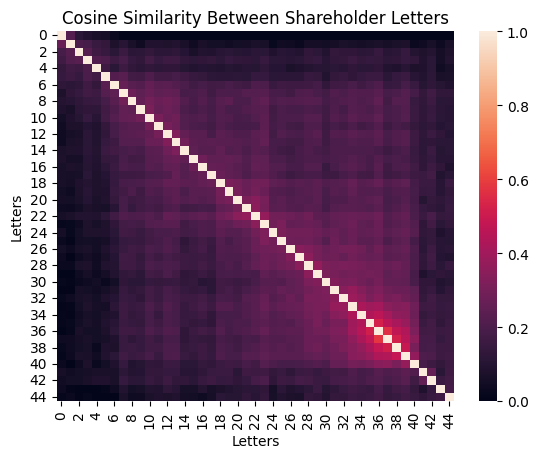

In [6]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Normalize values in the cosine matrix
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(cos_df.values)

# Graph a heatmap for comparing similarity between letters
hm = sns.heatmap(scaled_df)
hm.set(xlabel='Letters', ylabel='Letters', title='Cosine Similarity Between Shareholder Letters')

# Similarity - Term Frequency-Inverse Document Frequency
Even less similarity is shown between the letters after calculated cosine distance between the tfidf vectors. This was probably to be expected given that tfidf produces continuous values from 0-1, unlike count vectorization which produces binary values of 0 or 1, so the tfidf vectors have less intense values that seem to show less intense cosine distances.

[Text(0.5, 23.52222222222222, 'Letters'),
 Text(50.722222222222214, 0.5, 'Letters'),
 Text(0.5, 1.0, 'Cosine Similarity Between Shareholder Letters')]

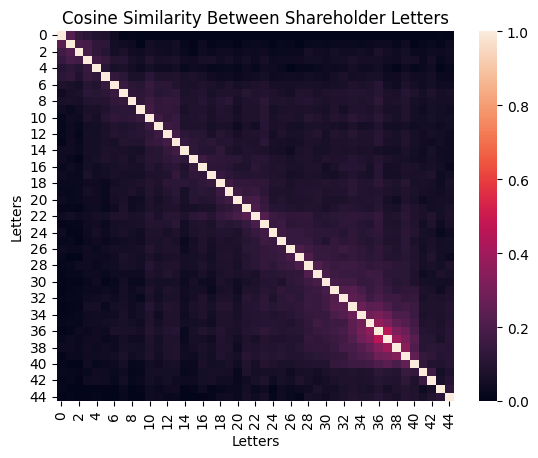

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

# Use tfidf transformer on count vector from above
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(words_vector)

# Create a matrix to store distances between letters
cos_matrix = np.zeros((45, 45))

# Calculate cosine distance between all letters
for i, vector1 in enumerate(tfidf.toarray()):
    for j, vector2 in enumerate(tfidf.toarray()):
        cos_matrix[i][j] = round(np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2)), 4)

# Normalize values in the cosine matrix
scaled_df = scaler.fit_transform(cos_matrix)

# Graph a heatmap for comparing similarity between letters
hm = sns.heatmap(scaled_df)
hm.set(xlabel='Letters', ylabel='Letters', title='Cosine Similarity Between Shareholder Letters')

# Similarity - Training A Doc2Vec Model
The similarity findings from the trained Doc2Vec model show that letters are most closely related to letters written from adjacent years as seen by the brightest spots along the diagonal from the top left to the bottom right of the graph. Any spurious similarity caused by performances of the stock market don't seem to appear. One possible explanation for these results could be that Warren Buffett's writing style changes year over year and letters written in similar time frames are the most like each other. The model could also not have enough training data for these results to be valid, having only 45 documents with an average of 10,000 words and 500 sentences per document.

In [12]:
import gensim

# Join sentences together for each letter and create a tagged documents
data = []
for i, letter in enumerate(df_sents['Letter']):
    data.append(' '.join(letter))
tagged_data = [gensim.models.doc2vec.TaggedDocument(
    words=nltk.word_tokenize(doc.lower()), 
    tags=[str(i)]) for i, doc in enumerate(data)
    ]

# Build Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=80)
model.save('data/doc2vec.model')

In [13]:
import gensim
import os

# Skip above cell if model is already trained and save
try: model = gensim.models.doc2vec.Doc2Vec.load('data/doc2vec.model')
except: 'No such file or directory'

# Find distance between each document
df_d2v = pd.DataFrame()
num_vec = len(model.dv.vectors)
for i in range(num_vec):
    distances = []
    for j in range(num_vec):
        distances.append(model.dv.similarity(i, j))
    df_d2v[1977+i] = distances
df_d2v.head()

,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1.000000,0.868932,0.802254,0.788084,0.751159,0.710929,0.719297,0.716912,0.671006,0.704563,...,0.146432,0.123860,0.167748,0.170778,0.149814,0.160265,0.281117,0.329827,0.232810,0.230433
1,0.868932,1.000000,0.891249,0.868152,0.822115,0.833449,0.829307,0.875673,0.875189,0.792041,...,0.020979,-0.022248,-0.005297,0.007370,-0.025869,-0.059168,0.038885,0.038816,0.051239,0.013113
2,0.802254,0.891249,1.000000,0.896656,0.810485,0.761506,0.797177,0.867545,0.857228,0.794619,...,0.180756,0.170043,0.176988,0.168060,0.155096,0.158284,0.257836,0.221817,0.259788,0.209044
3,0.788084,0.868152,0.896656,1.000000,0.926390,0.872746,0.843679,0.894674,0.879934,0.764556,...,0.010369,-0.028367,-0.025202,0.011431,0.012825,-0.043149,0.132271,0.154497,0.102223,0.071942
4,0.751159,0.822115,0.810485,0.926390,1.000000,0.938649,0.897835,0.903233,0.813912,0.790777,...,-0.031219,-0.071732,-0.067123,-0.047912,-0.056521,-0.104536,0.062699,0.166482,0.065904,0.034989


[Text(0.5, 23.52222222222222, 'Letters'),
 Text(50.722222222222214, 0.5, 'Letters'),
 Text(0.5, 1.0, 'Similarity Between Shareholder Letters')]

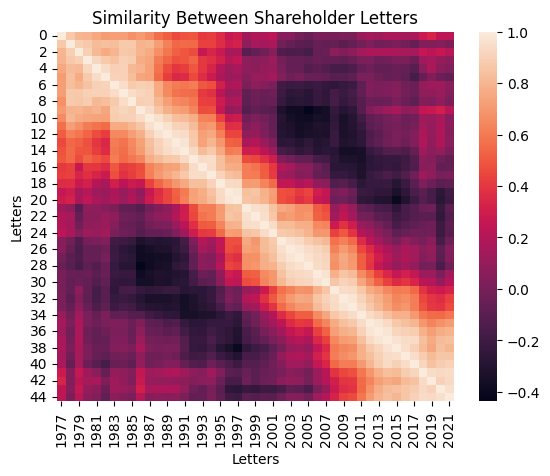

In [15]:
# Graph a heatmap for comparing similarity between letters
hm = sns.heatmap(df_d2v)
hm.set(xlabel='Letters', ylabel='Letters', title='Similarity Between Shareholder Letters')